#Code

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/Trap_simulation

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Trap_simulation


In [0]:
#@title import
import numpy as np
import torch
import time
from stopwatch import timer
import dill
from scipy.interpolate import RegularGridInterpolator
import numba
from numba import cuda

# matplotlib imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('image', cmap='Reds')
%matplotlib inline

In [0]:
@numba.jit()
def int3d(x,y,z):
    x_ = 1-x
    y_ = 1-y
    z_ = 1-z
    out = [
           [[x_*y_*z_,x_*y_*z],
            [x*y_*z_,x*y_*z]],
           
           [[y*x_*z_,y*x_*z],
            [x*y*z_,x*y*z]]
        ]
    return np.array(out)

# @timer
@numba.jit()
def interp3d(x,y,z,m):
    c = int3d(x,y,z)
    return np.sum(m*c)

@numba.jit()
def interpolate3d(x_axis, y_axis, z_axis, x, y, z, data):
    x_min = x_axis[0]
    x_step = x_axis[1] - x_axis[0]
    x_ind = int((x-x_min)//x_step)
    x0 = ((x-x_min)%x_step)/x_step

    y_min = y_axis[0]
    y_step = y_axis[1] - y_axis[0]
    y_ind = int((y-y_min)//y_step)
    y0 = ((y-y_min)%y_step)/y_step

    z_min = z_axis[0]
    z_step = z_axis[1] - z_axis[0]
    z_ind = int((z-z_min)//z_step)
    z0 = ((z-z_min)%z_step)/z_step

    data_short = data[x_ind:x_ind+2, y_ind:y_ind+2, z_ind:z_ind+2]

    return interp3d(y0, x0, z0, data_short)

@numba.jit()
def get_field_for_array(x_axis, y_axis, z_axis, x_arr, y_arr, z_arr, data): 
    N = len(x_arr) 
    out = np.zeros(N)

    for i in range(N):
        x = x_arr[i]
        y = y_arr[i]
        z = z_arr[i]

        out[i] = interpolate3d(x_axis, y_axis, z_axis, x, y, z, data)
    
    return out

# self=trap
# E = self.electrodes['rod1'].field
# o = get_field_for_array(self.axis[0],self.axis[1],self.axis[2], self.ansamble.x, self.ansamble.y, self.ansamble.z, E[0][:])
# print(o)

In [0]:
#@title Mesh_3d
class Mesh_3d(np.ndarray):
    '''
    Mesh_3d extends np.ndarray.
    It contains the same array data, like np.ndarray, but also has got the axis attribute.
    Axis attribute is array of 3 arrays, correspondes to 3 axis, which allow to link array value to its position.
    Number of items at each of the axis subarray is the number of array data points at the corresponding direction.
    For example if the Mesh3d object has shape (l, m, n), the axis consists of 3 arrays with shapes (l,), (m,) & (n,)
    Axis attribute allow to link array value to its position.
    For example: array element with indeices [i][j][k] corresponds to the position
        x=axis[0][i], y=axis[1][j], z=axis[2][k]
    '''
    def __new__(subtype, shape=0, dtype=float, buffer=None, offset=0, strides=None, order=None, axis=None):
    	# TODO initialize with zeros
        # TODO initialize with input array + axis
        if axis is None:
            raise TypeError("Required argument 'axis' not found")
        if type(axis) != np.ndarray:
            raise TypeError("axis: expected np.ndarray, but got '{}'".format(type(axis)))
        if axis.shape[0] != 3:
            raise ValueError("axis: expected to have shape (3, x), but got '{}'".format(axis.shape))
        shape = (len(axis[0]), len(axis[1]), len(axis[2]))
        obj = super(Mesh_3d, subtype).__new__(subtype, shape, dtype,
                                                buffer, offset, strides,
                                                order)
        obj.axis = axis
        return obj

    def __array_finalize__(self, obj):
        # TODO initialize with zeros
        if obj is None: return
        self.info = getattr(obj, 'info', None)
           
    def zeroing(self):
        self[:] = np.zeros_like(self[:])
        return None

    def set_data(self, data):
        self[:] = data[:]
        return None
        
    def get_section(self, plane, coordinate):
        planes = {'x':0, 'y':1, 'z':2}
        i = planes[plane]
        ax = self.axis[i]
        
        index = (np.abs(ax - coordinate)).argmin() # index of ax[] element nearest to the desired coordinate
        
        full_slice = slice(None,None)
        slice_var = [full_slice, full_slice, full_slice]
        slice_var[i] = index
        slice_var = tuple(slice_var)    

        out = self[slice_var]
        # out = out.transpose() 
        
        return out
    
    # @timer
    def get_nearest_point_value(self, x, y, z):
        # x_ind = (np.abs(self.axis[0] - x)).argmin() # index of ax[] element nearest to the desired coordinate
        # y_ind = (np.abs(self.axis[1] - y)).argmin()
        # z_ind = (np.abs(self.axis[2] - z)).argmin()
        # start = time.time()
        # bias = self[0,0,0]

        x_min = self.axis[0][0]
        x_step = self.axis[0][1] - self.axis[0][0]
        x_ind = int((x-x_min)//x_step)
        x0 = ((x-x_min)%x_step)/x_step

        y_min = self.axis[1][0]
        y_step = self.axis[1][1] - self.axis[1][0]
        y_ind = int((y-y_min)//y_step)
        y0 = ((y-y_min)%y_step)/y_step

        z_min = self.axis[2][0]
        z_step = self.axis[2][1] - self.axis[2][0]
        z_ind = int((z-z_min)//z_step)
        z0 = ((z-z_min)%z_step)/z_step

        data_short = self[x_ind:x_ind+2, y_ind:y_ind+2, z_ind:z_ind+2]

        return interp3d(y0, x0, z0, data_short)
    
    @timer
    def get_nearest_point_value2(self, x, y, z):
        # print(x, y, z)
        # print(np.min(self.axis[0]), np.min(self.axis[1]), np.min(self.axis[2]))
        # print(np.max(self.axis[0]), np.max(self.axis[1]), np.max(self.axis[2]))
        my_interpolating_function = RegularGridInterpolator((self.axis[0], self.axis[1], self.axis[2]), self[:], method='linear')
        out = my_interpolating_function(np.array([x, y, z]))[0]
        return out
    
    def interpolate_point_vale(self):
        # TODO
        pass
    
    def plot_slice(self, axis, coordinate):
        # TODO
        pass

In [0]:
#@title Geometry
class Geometry(Mesh_3d): 
    def create_uber_ring_3d(self, r0, thickness, x0=0, y0=0, z0=0):
        x, y, z = self.axis
        xx, yy, zz = np.meshgrid(x,y,z, sparse=True, indexing='ij')
        
        xx -= x0 # shifting the origin
        yy -= y0
        zz -= z0
        
        r = np.sqrt(xx**2 + yy**2)
        r_outter = r0
        r_inner = r_outter-thickness
        tube = (r <= r_outter) * (r >= r_inner)

        b1 = xx>(0-thickness/2)
        b2 = xx<(0+thickness/2)
        b3 = yy>r_outter-thickness/2
        tail = b1*b2*b3

        z1 = zz < 0+thickness/2
        z2 = zz > 0-thickness/2
        z = z1*z2

        self[:] = 1.0*(tube + tail)*z     
        return None
    
    def create_cylinder(self, r0, x0=0, y0=0, z_start=0, z_len=0):
        x, y, z = self.axis
        xx, yy, zz = np.meshgrid(x,y,z, sparse=True, indexing='ij')
        
        xx -= x0 # shifting the origin
        yy -= y0
        # zz -= z0
        
        r = np.sqrt(xx**2 + yy**2)
        cyl = r<r0
        
        z_end = z_start + z_len
        z = (zz > z_start) * (zz < z_end)
        out = 1.0 * cyl *z

        self[:] = out
        return None

    def create_diaphragm(self, r_out, r_hole, thickness, z0=0 ):
        x, y, z = self.axis
        xx, yy, zz = np.meshgrid(x,y,z, sparse=True, indexing='ij')
        
        zz -= z0
        
        r = np.sqrt(xx**2 + yy**2)
        aperture = (r <= r_out) * (r >= r_hole)

        z1 = zz < 0+thickness/2
        z2 = zz > 0-thickness/2
        z = z1*z2

        self[:] = 1.0*aperture*z     
        return None


    def create_cap(self):
        x, y, z = self.axis
        xx, yy, zz = np.meshgrid(x,y,z, sparse=True, indexing='ij')
        
        c = np.zeros_like(zz)

        c[0][0][0] = 1
        c[0][0][-1] = -1

        out = 1.0 * c * np.ones_like(xx) * np.ones_like(yy)

        self[:] = out
        return None

In [0]:
#@title Potential
class Potential(Mesh_3d):
    pass

In [0]:
#@title Electrode
class Electrode():
    def __init__(self, name, axis):
        self.name = name
        self.axis = axis
        self.geometry = Geometry(axis=axis)
        self.potential = Potential(axis=axis)
        self.field = []
        self.interpolate_field_x = None
        self.interpolate_field_y = None
        self.interpolate_field_z = None
        self.time_dependence = lambda x: 1

    def set_time_dependence(self, f):
        self.time_dependence = f
        
    def calc_phi(self, mask_all=None, maxiter=int(1e6), rtol=1e-6, cuda=None):
        # TODO get rid of shitcode
        '''
        Function used to calculate potential of a givven electrode

        Parameters:
                self
                maxiter - int, maximum number of iterations to perform
                rtol - float, relative tolerance for convergence
                cuda - bool, if cuda computation mode is active

        Returns:
                potential object
        '''
        start = time.time()
        if cuda is None:
            cuda = torch.cuda.is_available()

        s2 = 1/np.sqrt(2)
        s3 = 1/np.sqrt(3)
        # kernel = np.array([[[s3,s2,s3],[s2,1,s2],[s3,s2,s3]],[[s2,1,s2],[1,0,1],[s2,1,s2]],[[s3,s2,s3],[s2,1,s2],[s3,s2,s3]]])
        kernel = np.array([[[0,0,0],[0,1,0],[0,0,0]],[[0,1,0],[1,0,1],[0,1,0]],[[0,0,0],[0,1,0],[0,0,0]]])
        kernel = kernel/np.sum(kernel)
        kernel = torch.from_numpy(kernel)
        kernel.unsqueeze_(0) #just because weight should have at least three dimensions
        kernel.unsqueeze_(0)
        if cuda:
            kernel = kernel.cuda()
        conv = torch.nn.Conv3d(1, 1, (3,3), stride=1,  bias=False, padding_mode='zeros', padding=1)
        conv.weight.data = kernel

        input1 = torch.from_numpy(self.geometry)
        input1.unsqueeze_(0)
        input1.unsqueeze_(0)
        # input1 = input1.float()
        
        if cuda:
            input1 = input1.cuda()
        phi = torch.zeros_like(input1)
        phi.copy_(input1)
        if cuda:
            phi = phi.cuda()
        mask_all = torch.tensor(mask_all)
        mask_all.unsqueeze_(0)
        mask_all.unsqueeze_(0)
        mask = phi != 0

        output = torch.zeros_like(input1)
        
        ite = 0  # iteration index
        diff = rtol + 0.1  # initial difference
        diffs = []
        while diff>rtol and ite<maxiter:
            output = conv(input1)
            output.detach_()
            output[mask_all] = 0
            output[mask] = phi[mask]
            diff = torch.sum(torch.abs(output-input1))/torch.sum(torch.abs(output))
            input1 = output
            input1.detach_()
            # torch.cuda.empty_cache()
            diffs.append(diff)
            ite += 1
            # mem_test()
        print("Electrode '{}' simulated".format(self.name))
        print("CUDA is {}".format(cuda))
        print('Simulation took {:.2e} sec'.format(time.time() - start))
        print('{} iterations made. Final relative tolerance is {:.2e}'.format(ite, diff))
        if cuda:
            out = input1.cpu().data.numpy()[0][0]
        else:
            out = input1.cpu().data.numpy()[0][0]
            # torch.cuda.empty_cache()
        self.potential[:] = out
        return diffs

    def calc_field(self):
        step_x = self.axis[0][1] - self.axis[0][0]
        E = np.gradient(self.potential)
        Ex = Potential(axis=self.axis)
        Ex.set_data(-1*E[0]/step_x)

        step_y = self.axis[1][1] - self.axis[1][0]
        Ey = Potential(axis=self.axis)
        Ey.set_data(-1*E[1]/step_y)

        step_z = self.axis[2][1] - self.axis[2][0]
        Ez = Potential(axis=self.axis)
        Ez.set_data(-1*E[2]/step_z)

        self.field = [Ex, Ey, Ez]

        self.interpolate_field_x = RegularGridInterpolator((self.axis[0], self.axis[1], self.axis[2]), Ex, method='linear')
        self.interpolate_field_y = RegularGridInterpolator((self.axis[0], self.axis[1], self.axis[2]), Ey, method='linear')
        self.interpolate_field_z = RegularGridInterpolator((self.axis[0], self.axis[1], self.axis[2]), Ez, method='linear')
        return None

    def get_potential_at_time(self, t=0):
        return self.time_dependence(t) * self.potential

    def get_field_at_time(self, t=0):
        Ex, Ey, Ez = self.field
        c = self.time_dependence(t)
        return [c*Ex, c*Ey, c*Ez]

In [0]:
#@title Ansamble
class Ansamble():
    def __init__(self):
        self.device = 'cuda'
        self.mass = 232*1.6e-27 # kg
        self.charge = 3*1.6e-19 # Coulomb
        self.N = 0
        self.ion_id = torch.tensor([], device=self.device, dtype=int)
        self.x = torch.tensor([], device=self.device)
        self.y = torch.tensor([], device=self.device)
        self.z = torch.tensor([], device=self.device)
        self.vx = torch.tensor([], device=self.device)
        self.vy = torch.tensor([], device=self.device)
        self.vz = torch.tensor([], device=self.device)
        self.trajectory = {}
  
    def add_ion(self, r, v):
        x, y, z = r
        vx, vy, vz = v
        self.x = torch.cat((self.x, torch.tensor([float(x)], device=self.device)))
        self.y = torch.cat((self.y, torch.tensor([float(y)], device=self.device)))
        self.z = torch.cat((self.z, torch.tensor([float(z)], device=self.device)))
        self.vx = torch.cat((self.vx, torch.tensor([float(vx)], device=self.device)))
        self.vy = torch.cat((self.vy, torch.tensor([float(vy)], device=self.device)))
        self.vz = torch.cat((self.vz, torch.tensor([float(vz)], device=self.device)))

        if self.N != 0:
            name = int(self.ion_id[-1]+1)
        else:
            name = 0
        self.ion_id = torch.cat((self.ion_id, torch.tensor([name], device=self.device)))
        self.trajectory[self.N] = []
        self.N += 1

    def remove_ion(self, ion_id, t):
        try:
            i = int(torch.nonzero(self.ion_id == ion_id)[0][0])
        except IndexError:
            print('You are trying to delete ion with wrong ion_id. No such ion founded. Removing aborted')
            return None
        ion_name = self.ion_id[i].cpu().numpy()

        def torch_remove(t, i):
            return torch.cat((t[:i],t[i+1:]))

        self.N -= 1
        self.x = torch_remove(self.x, i)
        self.y = torch_remove(self.y, i)
        self.z = torch_remove(self.z, i)
        self.vx = torch_remove(self.vx, i)
        self.vy = torch_remove(self.vy, i)
        self.vz = torch_remove(self.vz, i)
        self.ion_id = torch_remove(self.ion_id, i)

        print('Ion #{} is removed from computations. {} ions left. Current time: {:.2e} sec'.format(ion_name, self.N, t))

    # @timer
    def move(self, a, dt, log=False):
        ax = torch.tensor(a[0], device=self.device)
        ay = torch.tensor(a[1], device=self.device)
        az = torch.tensor(a[2], device=self.device)

        self.vx = self.vx + ax*dt
        self.vy = self.vy + ay*dt
        self.vz = self.vz + az*dt

        self.x = self.x + self.vx*dt
        self.y = self.y + self.vy*dt
        self.z = self.z + self.vz*dt

        if log:
            for i in range(self.N):
                name = self.ion_id.cpu().numpy()[i]
                self.trajectory[name].append(np.copy([self.x.cpu().numpy()[i], self.y.cpu().numpy()[i], self.z.cpu().numpy()[i]]))
        
    def ion_source(self, N, x0, y0, z0, dx, dy, dz, dvx, dvy, dvz, distribution='gauss'):
        vx = 0
        vy = 0
        vz = 0

        if distribution == 'gauss':
            x = np.random.normal(x0, dx, N)
            y = np.random.normal(y0, dy, N)
            z = np.random.normal(z0, dz, N)
            for i in range(N):
                self.add_ion([x[i], y[i], z[i]], [vx, vy, vz])
        elif distribution == 'uniform':
            n = int(np.cbrt(N))
            x = np.linspace(x0-dx, x0+dx, n) + (np.random.rand(n)-0.5)*dx/1
            y = np.linspace(y0-dy, y0+dy, n) + (np.random.rand(n)-0.5)*dy/1
            z = np.linspace(z0-dz, z0+dz, n) + (np.random.rand(n)-0.5)*dz/1
            for i in range(n):
                for j in range(n):
                    for k in range(n):
                        p = 0.1
                        rx = (np.random.rand()-0.5)*dx*p
                        ry = (np.random.rand()-0.5)*dy*p
                        rz = (np.random.rand()-0.5)*dz*p
                        self.add_ion([x[i]+rx, y[j]+ry, z[k]+rz], [vx, vy, vz])
        else:
            raise ValueError ("Unknown 'type' argument in the 'ion_source' function")

        
        # vx = np.random.normal(0, dvx)
        # vy = np.random.normal(0, dvy)
        # vz = np.random.normal(0, dvz)
        

    # @timer
    def interaction2(self):
        k = 8.9875517923e9
        q = self.charge
        f_out = [[], [], []]
        
        xx = self.x.repeat(1,self.N).reshape([self.N,self.N])
        rx = xx - xx.T
        del xx

        yy = self.y.repeat(1,self.N).reshape([self.N,self.N])
        ry = yy - yy.T
        del yy

        zz = self.z.repeat(1,self.N).reshape([self.N,self.N])
        rz = zz - zz.T
        del zz

        r = torch.sqrt(rx**2 + ry**2 + rz**2)

        f_i = k*q*q/r**3

        f_i[f_i == np.inf] = 0

        f_out[0] = (torch.sum(rx, dim=0)*torch.sum(f_i, dim=0)).cpu().numpy()
        f_out[1] = (torch.sum(ry, dim=0)*torch.sum(f_i, dim=0)).cpu().numpy()
        f_out[2] = (torch.sum(rz, dim=0)*torch.sum(f_i, dim=0)).cpu().numpy()
        
        return f_out

    def dissipation(self, gamma=[0,0,0]):
        # gamma = 0
        vz = self.vz
        Fx = -gamma[0]*self.vx
        Fy = -gamma[1]*self.vy
        Fz = -gamma[2]*self.vz
        return np.array([Fx.cpu().numpy(), Fy.cpu().numpy(), Fz.cpu().numpy()])

In [0]:
#@title Trap
class Trap:
    def __init__(self):
        self.t = 0
        self.axis = ()
        self.dim = ()
        self.electrodes = {}
        self.ansamble = Ansamble()

    def define_mesh(self, x_min, x_max, y_min, y_max, z_min, z_max, step):
        '''
        Function used for defining the mesh.
        
        
        Initialase axis & mesh objects wich is a tuple of 6 objects (x, y, z, xx, yy, zz):
                self.axis = (x,y,z) tuple of 1d np.arrays filled with evenly spaced values within a given interval
                self.mesh = (xx, yy, zz) tuple of 3d np.arrays filled along the each dimension with x, y, z respectively
        
        Parameters:
                x_min, x_max, y_min, y_max, z_min, z_max, step
                
        Returns: None
        '''
        x = np.arange(x_min, x_max, step)
        y = np.arange(y_min, y_max, step)
        z = np.arange(z_min, z_max, step)
        self.axis = np.array([x, y, z])
        self.dim = (len(x), len(y), len(z))
        return None 
    
    def add_electrode(self, name):
        a = Electrode(name, self.axis)
        self.electrodes[name] = a
        self.__dict__[name] = a
        
    def list_electrodes(self):
        for name in self.electrodes.keys():
            print(name)
            
    def calc_all(self, *arg, **kwarg):
        mask_all_electrodes = self.get_full_geometry() != 0
        for electrode_name in self.electrodes:
            self.electrodes[electrode_name].calc_phi(mask_all=mask_all_electrodes, *arg, **kwarg)
            self.electrodes[electrode_name].calc_field()
        return None
            
    def get_full_geometry(self, t=0):
        # TODO get rid og shit-code
        out = Geometry(axis=self.axis)
        out[:] = np.zeros_like(out) 
        for electrode_name in self.electrodes:
            out[:] += self.electrodes[electrode_name].geometry[:]
        return out
    
    def get_full_phi(self, t=0):
        out = Geometry(axis=self.axis)
        out[:] = np.zeros_like(out)
        for electrode_name in self.electrodes:
            out[:] += self.electrodes[electrode_name].get_potential_at_time(t)[:]
        for electrode_name in self.electrodes:
            mask = (self.electrodes[electrode_name].geometry[:] != 0)
            out[mask] = self.electrodes[electrode_name].get_potential_at_time(t)[mask]
        return out
    
    def get_phi_at_point(self, t=0, x=None, y=None, z=None):
        phi_out = 0
        for electrode_name in self.electrodes:
            c_t = self.electrodes[electrode_name].time_dependence(t)
            try:
                phi_out += c_t*self.electrodes[electrode_name].potential.get_nearest_point_value(x, y, z)
            except ValueError:
                print('Point is out of trap area')
                return None
        return phi_out

    def get_full_field(self, t=0):
        Ex_ = Potential(axis=self.axis)
        Ex_.zeroing()
        Ey_ = Potential(axis=self.axis)
        Ey_.zeroing()
        Ez_ = Potential(axis=self.axis)
        Ez_.zeroing()
        for electrode_name in self.electrodes:
            E_ = self.electrodes[electrode_name].get_field_at_time(t) 
            start1 = time.time()
            Ex_ += E_[0] 
            Ey_ += E_[1] 
            Ez_ += E_[2]   
        return [Ex_, Ey_, Ez_]
    
    # @timer
    def get_field_at_point(self, t=0, x=None, y=None, z=None):
        # start = time.time()
        out = [[], [], []]
        x_min = self.axis[0][0]
        x_max = self.axis[0][-1]
        y_min = self.axis[1][0]
        y_max = self.axis[1][-1]
        z_min = self.axis[2][0]
        z_max = self.axis[2][-1]
        # print('Init: {:.2e} sec'.format(time.time() - start))
        self.remove_outsiders()
        if len(self.ansamble.ion_id) == 0:
            print('No ions left')
            return None
        for ion_id in self.ansamble.ion_id:
            E_out = [0, 0, 0]
            i = np.where(self.ansamble.ion_id == ion_id)[0][0]
            x0 = self.ansamble.x[i]
            y0 = self.ansamble.y[i]
            z0 = self.ansamble.z[i]

            for electrode_name in self.electrodes:
                c_t = self.electrodes[electrode_name].time_dependence(t)
                E = self.electrodes[electrode_name].field
                # start = time.time()
                # print('get_field_for_array: {:.2e} sec'.format(time.time() - start))
                # start_loop = time.time()
                for i in range(3):
                    # start = time.time()
                    E_at_point = E[i].get_nearest_point_value(x0, y0, z0)
                    E_out[i] += c_t*E_at_point
                    # print('get_nearest_point_value: {:.2e} sec'.format(time.time() - start))
                # print('Loop: {:.2e} sec'.format(time.time() - start_loop))
            # print('Calc: {:.2e} sec'.format(time.time() - start_calc))
            start = time.time()
            out[0].append(E_out[0])
            out[1].append(E_out[1])
            out[2].append(E_out[2])
        # print('Fin: {:.2e} sec'.format(time.time() - start))
        return np.array(out)

    # @timer
    def get_field_at_point2(self, t=0, x=None, y=None, z=None):
        if len(self.ansamble.ion_id) == 0:
            print('No ions left')
            return None

        n_ions = len(self.ansamble.ion_id)
        E_out = np.zeros((3,n_ions))

        for electrode_name in self.electrodes:
            c_t = self.electrodes[electrode_name].time_dependence(t)
            E = self.electrodes[electrode_name].field

            Ex = get_field_for_array(self.axis[0],self.axis[1],self.axis[2], self.ansamble.x, self.ansamble.y, self.ansamble.z, E[0][:])
            Ey = get_field_for_array(self.axis[0],self.axis[1],self.axis[2], self.ansamble.x, self.ansamble.y, self.ansamble.z, E[1][:])
            Ez = get_field_for_array(self.axis[0],self.axis[1],self.axis[2], self.ansamble.x, self.ansamble.y, self.ansamble.z, E[2][:])

            E_electrode = c_t*np.array([Ex, Ey, Ez])
            E_out += E_electrode
        return E_out

    def get_ideal_field(self, t=0, x=None, y=None, z=None):
        if len(self.ansamble.ion_id) == 0:
            print('No ions left')
            return None
        V = 408
        U = 0
        f = 2.4e6
        r0 = 3.55e-3
        V_ring = 1000
        d = 30e-3
        c_t = 2*(V*np.cos(2*np.pi*f*t)+U)/r0**2
        z0 = (self.axis[2][0] + self.axis[2][-1])/2
        Ex =  c_t*self.ansamble.x
        Ey = -c_t*self.ansamble.y
        Ez = -2*V_ring/d**2*(self.ansamble.z-z0)
        return np.array([Ex.cpu().numpy(),Ey.cpu().numpy(),Ez.cpu().numpy()])

    def remove_outsiders(self):
        x = self.ansamble.x
        y = self.ansamble.y
        z = self.ansamble.z

        x_min = self.axis[0][0]
        x_max = self.axis[0][-1]

        y_min = self.axis[1][0]
        y_max = self.axis[1][-1]

        z_min = self.axis[2][0]
        z_max = self.axis[2][-1]

        x_out = (x > x_max) + (x < x_min)
        y_out = (y > y_max) + (y < y_min) 
        z_out = (z > z_max) + (z < z_min)

        ions_out = torch.nonzero(x_out + y_out + z_out)
        ions_out_id = self.ansamble.ion_id[ions_out]

        for i in ions_out_id:
            self.ansamble.remove_ion(i, self.t)


    @timer
    def simulate(self, t_max, dt0, gamma=[0,0,0], min_ion_num=0, is_trap=True, is_dissipate=True, is_interact=True, stopwatch=False, max_iter=None, log=False):
        ite = 0

        q = self.ansamble.charge
        m = self.ansamble.mass
        while self.t < t_max and len(self.ansamble.ion_id)>min_ion_num:
            if ite % 2000 == 0:
                print('Current iteration = {}. {:.2e} sec simulated'.format(ite, self.t))
            force = np.zeros((3, self.ansamble.N), dtype=np.float64)
            if is_trap:
                start = time.time()
                # E =  trap.get_field_at_point2(t, self.ansamble.x, self.ansamble.y, self.ansamble.z)
                E  = trap.get_ideal_field(self.t)
                Fx, Fy, Fz = q*E
                if stopwatch:
                    print('get_field_at_point time: {:.2e} sec'.format(time.time() - start))
                force_trap = np.array([Fx,Fy,Fz], dtype=np.float64)
                # print(force_trap)
                force += force_trap
            if is_dissipate:
                start = time.time()
                dissipation = self.ansamble.dissipation(gamma)
                force += dissipation
                if stopwatch:
                    print('dissipate time: {:.2e} sec'.format(time.time() - start))
            if is_interact:
                start = time.time()
                force_interaction = self.ansamble.interaction2()
                # print(force_interaction)
                force += force_interaction
                if stopwatch:
                    print('interact time: {:.2e} sec'.format(time.time() - start))
            acceleration = force/self.ansamble.mass
            start = time.time()
            self.ansamble.move(acceleration, dt0, log)
            if stopwatch:
                print('move time: {:.2e} sec'.format(time.time() - start))
            self.remove_outsiders()
            self.t += dt0
            ite += 1
            if max_iter != None:
                if ite == max_iter:
                    break
        print('Ions left: {}'.format(len(self.ansamble.ion_id)))
        print('Simulation time: {:.2e} sec'.format(self.t))
        print('Steps made: {}'.format(ite))
   
    def reset_simulation(self):
        self.ansamble = Ansamble()

#Setting trap properties

In [0]:
%%time

a = 10e-3 # meters
step = 0.25e-3 # meters

z_lim = 20e-3

x_min = -a
x_max =  a
y_min = -a
y_max =  a
z_min = 0
z_max = 85e-3

x_axis=np.arange(x_min, x_max, step)
y_axis=np.arange(y_min, y_max, step)
z_axis=np.arange(z_min, z_max, step)

trap = Trap()

trap.define_mesh(x_min, x_max, y_min, y_max, z_min, z_max, step)

trap.add_electrode('rod1')
trap.add_electrode('rod2')
trap.add_electrode('rod3')
trap.add_electrode('rod4')

trap.add_electrode('rod1_bb')
trap.add_electrode('rod2_bb')
trap.add_electrode('rod3_bb')
trap.add_electrode('rod4_bb')

trap.add_electrode('ring1')
trap.add_electrode('ring2')

trap.add_electrode('d4')

r = 4*1e-3
d = 1.06773/2*1e-2
ring_thickness = 1e-3

gap = 1e-3
trap_z_start = gap
trap_len = 50e-3
trap_bb_start = 2*gap + trap_len
bb_len = 30e-3
d4_thikness = 1e-3
d4_z_pos = 3*gap + trap_len + bb_len + d4_thikness/2

trap.rod1.geometry.create_cylinder(r,d,d,trap_z_start,trap_len)
trap.rod2.geometry.create_cylinder(r,d,-d,trap_z_start,trap_len)
trap.rod3.geometry.create_cylinder(r,-d,d,trap_z_start,trap_len)
trap.rod4.geometry.create_cylinder(r,-d,-d,trap_z_start,trap_len)

trap.rod1_bb.geometry.create_cylinder(r,d,d, trap_bb_start, bb_len)
trap.rod2_bb.geometry.create_cylinder(r,d,-d, trap_bb_start, bb_len)
trap.rod3_bb.geometry.create_cylinder(r,-d,d, trap_bb_start, bb_len)
trap.rod4_bb.geometry.create_cylinder(r,-d,-d, trap_bb_start, bb_len)

trap.ring1.geometry.create_uber_ring_3d(0.33e-2, ring_thickness, 0, 0 , 11e-3)
trap.ring2.geometry.create_uber_ring_3d(0.33e-2, ring_thickness, 0, 0 , 41e-3)

trap.d4.geometry.create_diaphragm(9e-3, 1.5e-3, d4_thikness, d4_z_pos)

# trap.calc_all(rtol=1e-6)

CPU times: user 69.2 ms, sys: 62 ms, total: 131 ms
Wall time: 181 ms


In [193]:
def rf(V, U, f, phase=0):
    def wrapped(t):
        return V*np.sin(2*np.pi*f*t+phase) + U
    return wrapped

def const_volatage(U0):
    def wrapped(t):
        return U0
    return wrapped

def step(U0, t0, slope):
    def wrapped(t):
        if slope == '+':
            b = True
        if slope == '-':
            b = False
        return U0*((t > t0) == b)
    return wrapped



freq = 2.4e6 # Hz
U = 0 # Volts
V = 408 # RF Volts
r0 = 3.55e-3 # m
m = 232*1.6e-27 # kg
q = 3*1.6e-19 # Coulomb

rf1 = rf(V, U, freq, 0)
rf2 = rf(V, U, freq, np.pi)
ring_volatage = const_volatage(100)

trap.rod1.set_time_dependence(rf1)
trap.rod2.set_time_dependence(rf2)
trap.rod3.set_time_dependence(rf2)
trap.rod4.set_time_dependence(rf1)

trap.rod1_bb.set_time_dependence(rf1)
trap.rod2_bb.set_time_dependence(rf2)
trap.rod3_bb.set_time_dependence(rf2)
trap.rod4_bb.set_time_dependence(rf1)

trap.ring1.set_time_dependence(const_volatage(100))
trap.ring2.set_time_dependence(step(100, 200/freq, '-'))

trap.d4.set_time_dependence(const_volatage(-100))

a = 8*q*U/(m*(2*np.pi*freq)**2*r0**2)
q = 4*q*V/(m*(2*np.pi*freq)**2*r0**2)

print('a', a)
print('q', q)

a 0.0
q 0.7364012177385704


#Simulate

1.0
2176000


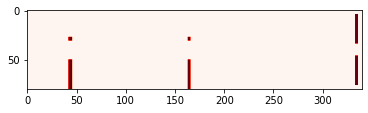

In [276]:
# LOAD

f = open('trap_dump/dump_trap', 'rb')
trap = dill.load(f)
f.close()
gg = trap.get_full_geometry()

print(np.max(gg))
print(len(gg.flatten()))
# plt.imshow(gg.get_section('x',d))
plt.imshow(gg.get_section('x',0))

In [277]:
%%time

trap.reset_simulation()
trap.t = 0

r0 = np.array([0.5e-3, 1e-3, 0.1e-3])
r01 = np.array([0.7e-3, 0.3e-3, 0.05e-3])
r02 = np.array([0.5e-3, 1e-3, 0e-3])
v0 = np.array([0, 0, 0])

trap_z_center = (trap.axis[2][0] + trap.axis[2][-1])/2

ion_num = 1000
dist = 'uniform'
trap.ansamble.ion_source(ion_num, 0, 0, trap_z_center, 5e-3,5e-3,5e-3,0,0,0, distribution=dist)

steps_per_cycle = 50
num_of_oscillations = 20000
period = 1/freq

t_max = 2e-3
# t_max = period*num_of_oscillations

dt = period/steps_per_cycle
g = 9e-18
gamma = [g,g,g]
print('dt: {:.2e} s'.format(dt))
trap.simulate(t_max, dt, gamma=gamma, is_trap=True, is_dissipate=True, is_interact=True, stopwatch=False, log=False, max_iter=steps_per_cycle*200, min_ion_num=1)

dt: 8.33e-09 s
Current iteration = 0. 0.00e+00 sec simulated
Ion #924 is removed from computations. 999 ions left. Current time: 4.75e-07 sec
Ion #934 is removed from computations. 998 ions left. Current time: 4.75e-07 sec
Ion #946 is removed from computations. 997 ions left. Current time: 5.25e-07 sec
Ion #949 is removed from computations. 996 ions left. Current time: 5.25e-07 sec
Ion #319 is removed from computations. 995 ions left. Current time: 1.14e-06 sec
Ion #406 is removed from computations. 994 ions left. Current time: 1.14e-06 sec
Ion #238 is removed from computations. 993 ions left. Current time: 3.03e-06 sec
Ion #236 is removed from computations. 992 ions left. Current time: 3.04e-06 sec
Ion #986 is removed from computations. 991 ions left. Current time: 3.46e-06 sec
Current iteration = 2000. 1.67e-05 sec simulated
Ion #351 is removed from computations. 990 ions left. Current time: 2.00e-05 sec
Ion #451 is removed from computations. 989 ions left. Current time: 2.00e-05 sec

In [0]:
#SAVE

# f = open('dump_trap', 'wb')
# dill.dump(trap, f)
# f.close()

#Results

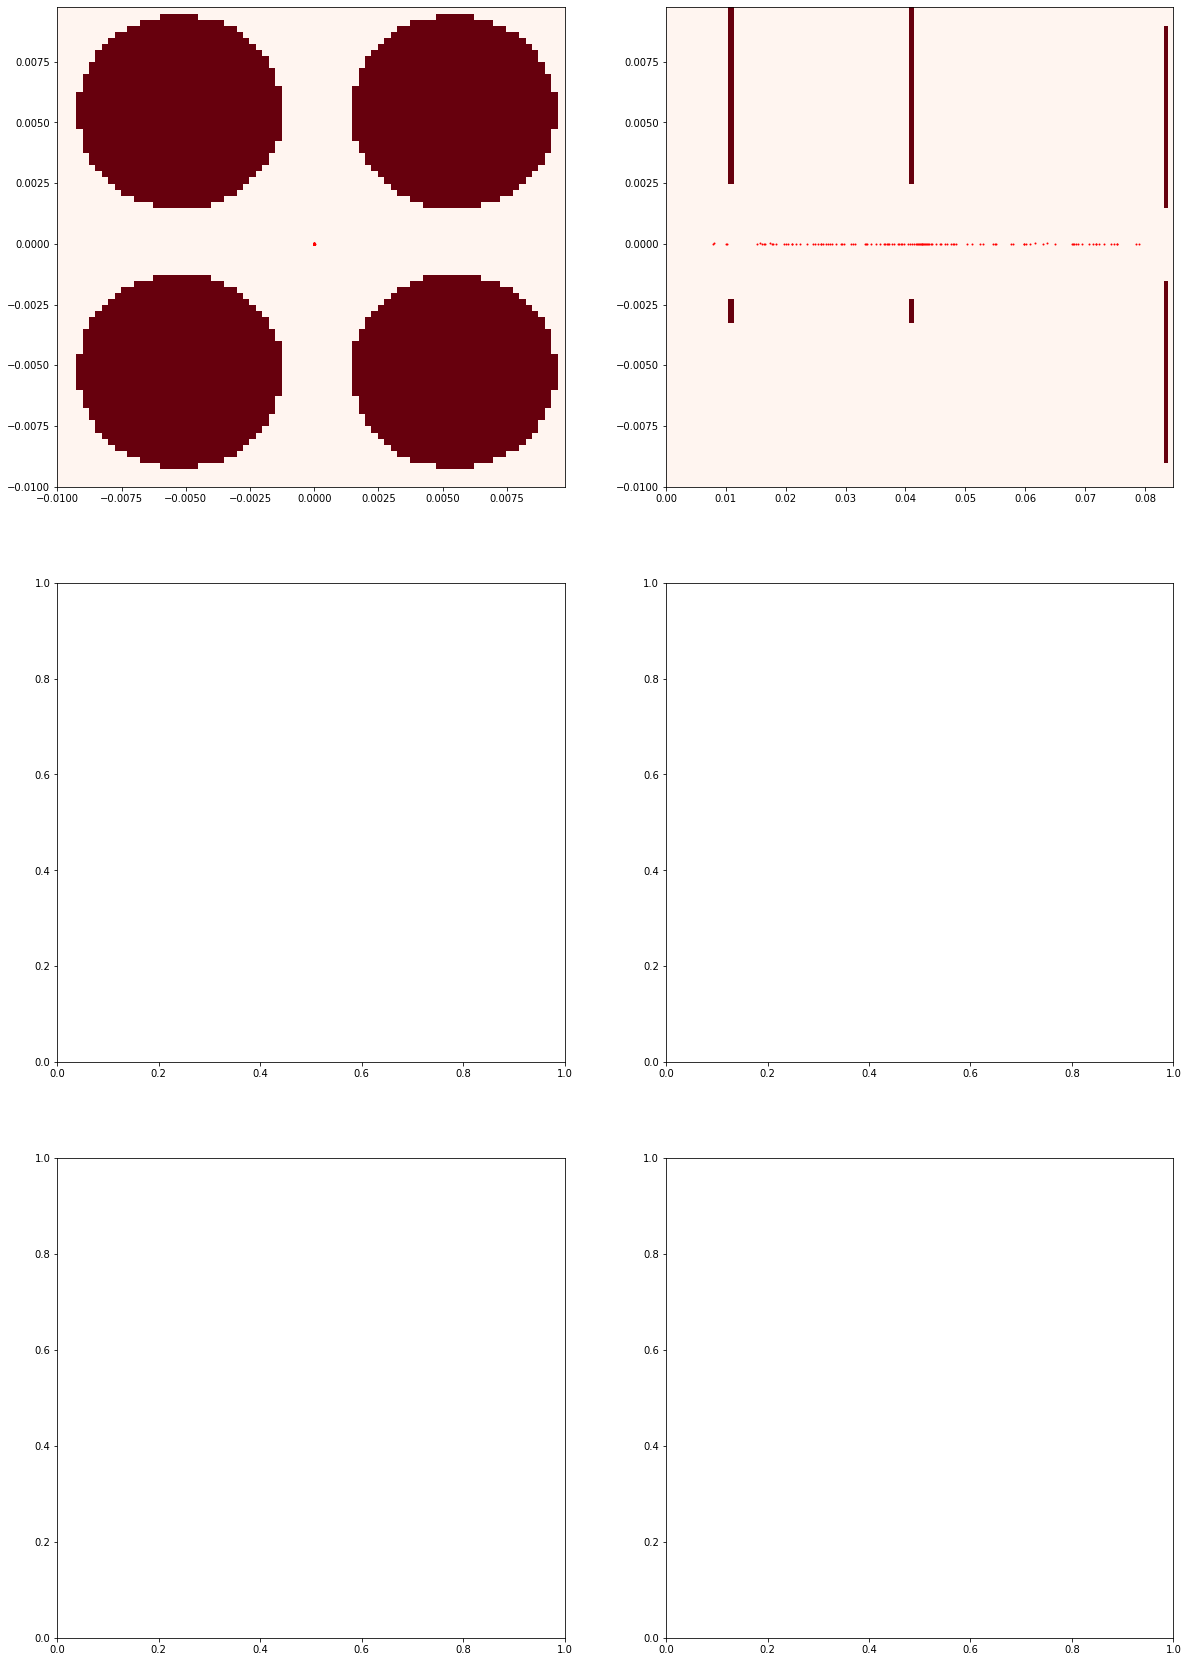

In [278]:
# %%time

phi3d = trap.get_full_geometry()
phi_xy = phi3d.get_section('z',trap_z_center)
phi_yz = phi3d.get_section('x',0)

fig, ax = plt.subplots(3,2, figsize=(20,30))

ax[0][0].pcolor(x_axis, y_axis, phi_xy)
ax[0][1].pcolor(z_axis, y_axis, phi_yz)



ions_left_id = trap.ansamble.ion_id.cpu().numpy()
# print(ions_left_id)

n1 = 0
n2 = -1
ss = 1

# count = {}

x = trap.ansamble.x.cpu()
y = trap.ansamble.y.cpu()
z = trap.ansamble.z.cpu()
ax[0][0].scatter(x,y, c='r', s=1)
ax[0][1].scatter(z,y, c='r', s=1)

# trajectory = trap.ansamble.trajectory
# # for ion_name in range(ion_num):
# for ion_name in ions_left_id:
# # for ion_name in [55]:
#     t = trajectory[ion_name]
#     x, y, z = np.array(t).T
#     # count[ion_name] = {'lifetime': len(z), 'fin_z': z[-1]}

#     ax[0][0].plot(x[n1:n2:ss],y[n1:n2:ss], linewidth=0.4, alpha=0.1)
#     ax[0][1].plot(z[n1:n2:ss],y[n1:n2:ss], linewidth=0.4, alpha=0.4)
#     ax[1][0].plot(x[n1:n2:ss], linewidth=0.5, alpha=0.3)
#     ax[1][1].plot(y[n1:n2:ss], linewidth=0.5, alpha=0.3)
#     ax[2][0].plot(z[n1:n2:ss], linewidth=1, alpha=1)
#     if len(x) > n1:
#         p = -1
#         ax[0][0].scatter(x[p],y[p], c='r', s=1)
#         ax[0][1].scatter(z[p],y[p], c='r', s=1)
# #     break

# print(count)

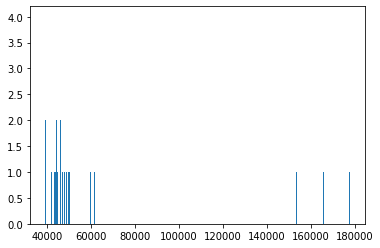

In [0]:
lifetimes = []

for ion in count:
    l = count[ion]['lifetime']
    if l>n1 and l < 200000:
        if count[ion]['fin_z'] > 80e-3:
            lifetimes.append(count[ion]['lifetime'])

# print(lifetimes)
plt.hist(lifetimes, bins=1000);

In [0]:
# import dill
# f = open('trah', 'wb')
# dill.dump(trajectory, f)
# f.close()

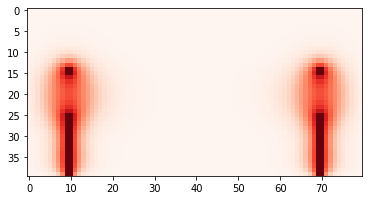

In [0]:
phi1 = trap.get_full_phi(1e6/4)
# phi2 = trap.ring2.potential
a1 = phi1.get_section('x', 0)
# a2 = phi2.get_section('y', 0)
plt.imshow(a1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


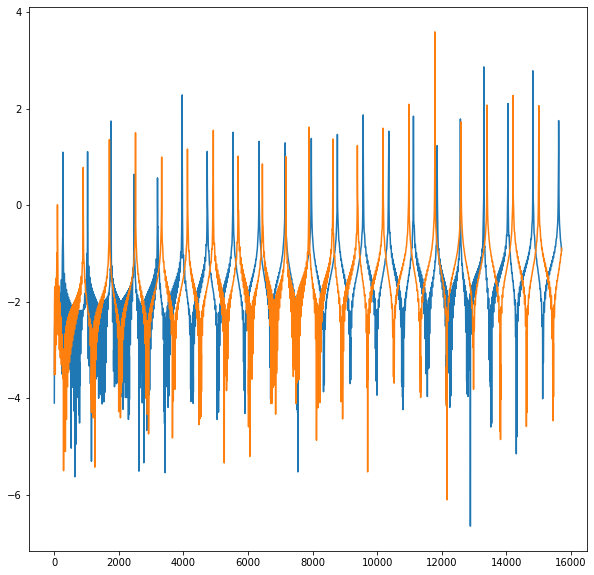

In [0]:
err = (r5 - r50[::10])/r50[::10]
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log10(np.abs(err)))

In [0]:
def run (frame, ax):
    print('FRAME: {}'.format(frame))
    ax.cla()
#     phi_mag = np.abs(field[frame])
#     ax.imshow(phi_mag)
    phi_angle = np.angle(field[frame])
    ax.imshow(phi_angle, cmap=cm.twilight)
    ax.set_title(frame)
    return None

xx, yy = np.meshgrid(x,y)

fig, ax = plt.subplots(figsize=(8,5))

ax.set_frame_on(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)


frames = 100
ani = animation.FuncAnimation(fig, run, frames=frames, fargs=[ax], interval=200, repeat=False)
# ani.save('trap_oscillating_3.mp4',fps=60, dpi=200)

In [0]:
# %%time

# def run (frame, ax, trap):
#     print('FRAME: {}'.format(frame))
#     ax.cla()
#     phi = trap.get_full_phi(frame)
#     p = phi.get_section('z', 0)
#     ax.plot_surface(xx, yy, p, rstride=1, cstride=1, cmap=cm.viridis)
#     ax.set_xlim(np.min(x), np.max(x))
#     ax.set_ylim(np.min(y), np.max(y))
#     ax.set_zlim(-1, 1)
#     ax.view_init(50, 135)
#     ax.set_title(frame)
#     return None

# xx, yy = np.meshgrid(x,y)

# fig = plt.figure()
# ax = Axes3D(fig)
# # fig, ax = plt.subplots(figsize=(8,5)))

# ax.set_frame_on(False)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)
# ax.plot_surface(xx, yy, E.get_section('z', 0), rstride=1, cstride=1, cmap=cm.viridis)



# frames = 300
# ani = animation.FuncAnimation(fig, run, frames=frames, fargs=[ax, trap], interval=200, repeat=False)
# ani.save('trap_oscillating_2.mp4',fps=60, dpi=200)

In [0]:
f = open('dump_trap', 'wb')
dill.dump(trap, f)
f.close()

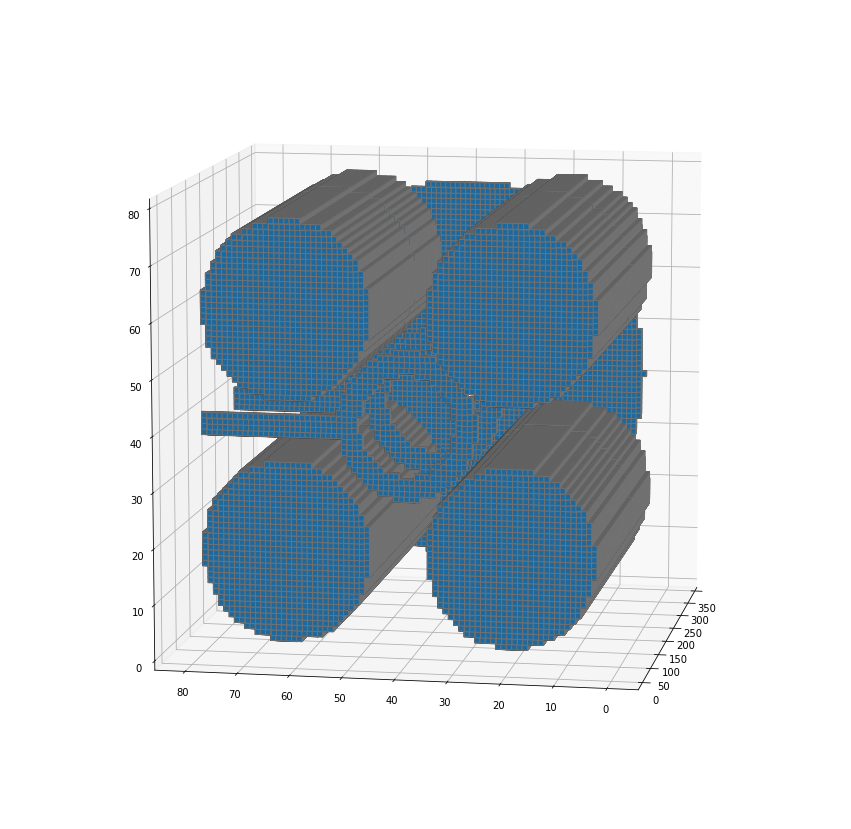

CPU times: user 8min 5s, sys: 3.51 s, total: 8min 9s
Wall time: 8min 8s


In [0]:
%%time

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')

gg = trap.get_full_geometry()
to_plot = gg[:,:,:].transpose()
ax.voxels(to_plot, edgecolors='gray')
ax.view_init(elev=10, azim=190)
plt.show()

In [0]:
print('{} {} '.format(15,16,17))

15 16 


#Push to GitHub

In [0]:
!git add Trap_simulation_structured.ipynb

In [0]:
!git status

On branch master
Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   Trap_simulation_structured.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	Ion trap simulation-Copy3.0.ipynb
	__pycache__/
	ansamble.py
	electrode.py
	geometry.py
	mesh_3d.py
	stopwatch.py
	test torch cuda nbody.ipynb
	trap_basic.py
	trap_dump/



In [0]:
!git commit

[master (root-commit) 2b8cae7] init commit
 1 file changed, 1 insertion(+)
 create mode 100644 Trap_simulation_structured.ipynb


In [0]:
!git push github master

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 630.55 KiB | 9.55 MiB/s, done.
Total 3 (delta 0), reused 0 (delta 0)
To https://github.com/481516/Trap_sim.git
 * [new branch]      master -> master


#Benchmark

In [0]:
N = 500
a = 1

x = np.linspace(0, N-1, N, dtype=np.int)
y = np.linspace(0, N-1, N, dtype=np.int)
z = np.linspace(0, N-1, N, dtype=np.int)

xx, yy, zz = np.meshgrid(x,y,z)

m = xx + yy + zz

x0, y0, z0 = 2.5, 2.5, 2.5

exact = x0 + y0 + z0
print(exact)

mm = Mesh_3d(axis=np.array([x,y,z]))
mm.set_data(m)
bb = mm.get_nearest_point_value(x0,y0,z0)
print('1', bb)
bb = mm.get_nearest_point_value2(x0,y0,z0)
print('2', bb)

7.5
1 7.5
2 7.5


In [0]:
%%time
for _ in range(1000):
    phi3d.get_nearest_point_value(x0,y0,z0)

print(phi3d.get_nearest_point_value(x0,y0,z0))    

0.9950752157810926
CPU times: user 10.2 ms, sys: 0 ns, total: 10.2 ms
Wall time: 10.7 ms


In [0]:
%%time
for _ in range(1000):
    phi3d.get_nearest_point_value2(x0,y0,z0)

print(phi3d.get_nearest_point_value2(x0,y0,z0))    

0.9950752157810926
CPU times: user 477 ms, sys: 72.3 ms, total: 550 ms
Wall time: 478 ms


#Testing

In [0]:
trap = Trap()

In [0]:
%time
N = 100
trap.ansamble.ion_source(N, 0, 0, 0, 0.01, 0.01, 0.01, 0, 0, 0)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [0]:
# print(trap.ansamble.ion_id)

In [0]:
# trap.ansamble.remove_ion(9)
# print(trap.ansamble.ion_id)
# trap.ansamble.add_ion(np.random.rand(3), np.random.rand(3))
# print(trap.ansamble.ion_id)

In [0]:
%%time

a = trap.ansamble.interaction2()

check took 5.17e-03 sec
CPU times: user 2.27 ms, sys: 19 µs, total: 2.29 ms
Wall time: 6.27 ms


In [0]:
print(np.random.normal(0,1,10))

[ 0.99688823  1.53474391 -0.08032675  1.07426964  0.99624311  0.64242787
  0.66729817  0.73468391 -0.49647381  0.52868348]


In [0]:
a = torch.tensor([[1,2],[3,4]], device='cuda')
print(a.cpu().numpy())

[[1 2]
 [3 4]]
